In [159]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [89]:
warnings.filterwarnings("ignore")

In [52]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploration Data Analysis

### First look of data

In [53]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Data descriptions can be seen [here](https://github.com/Zhenyu0521/Machine-Learning/blob/master/Advanced%20Regression%20Techniques%20for%20House%20Prices%20-%20Kaggle/data_description.txt) 

In [54]:
print("We have {} columns and {} records in total".format(len(df.columns), len(df)))

We have 81 columns and 1460 records in total


In [55]:
count_null = df.isnull().sum().sort_values(ascending=False)
percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
df_null = pd.concat([count_null, percent_null], axis=1, keys=['Total Missing', 'Percent'])
df_null.head(20)

,Total Missing,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


From the summarization of missing values, we find almost every feature that misses more than 40% of data is not the one we will consider during the process of choosing houses. (That may also explain why they missed so many data points). For other variables, let's decide whether to keep them or delete them after analyzing them.

### Analyzing dependent variable - SalePrice

In [56]:
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

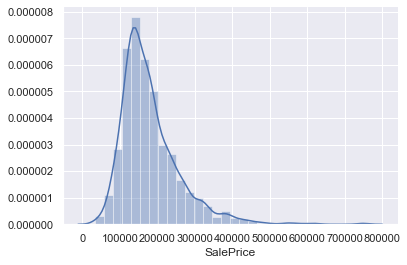

In [57]:
sns.distplot(df.SalePrice, bins=30, kde=True)
sns.despine(right=True)

In [58]:
print("The skewness of SalePrice is {}".format(round(df.SalePrice.skew(), 2)))
print("The kurtosis of SalePrice is {}".format(round(df.SalePrice.kurt(), 2)))

The skewness of SalePrice is 1.88
The kurtosis of SalePrice is 6.54


### Extract most relevant features

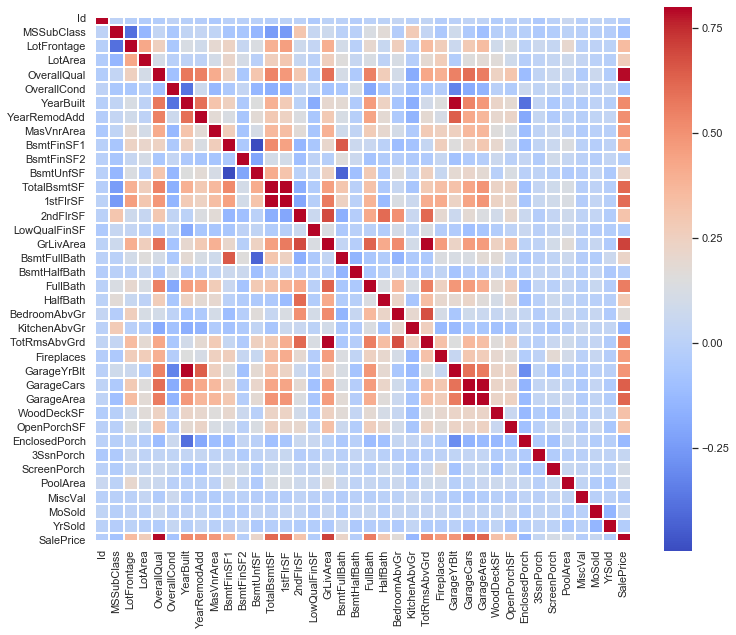

In [59]:
corr = df.corr()
fig = plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', linecolor='white', linewidths=1, vmax=0.8, square=True)

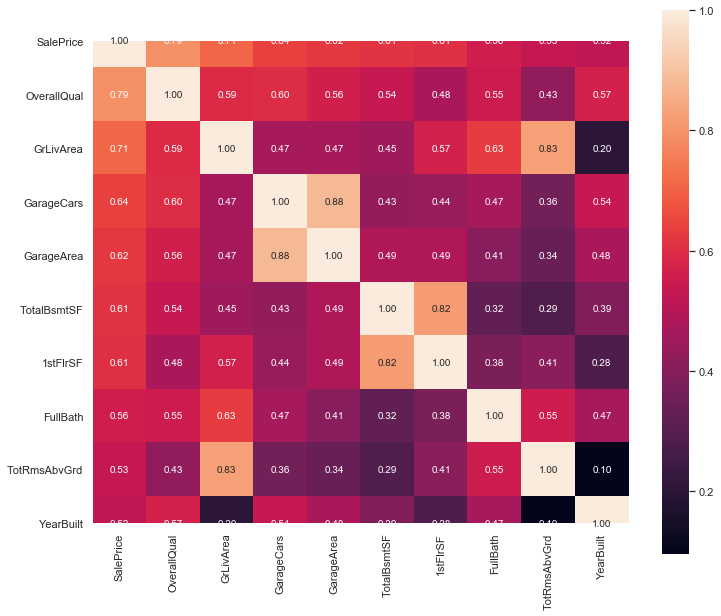

In [60]:
# Top 10 relevant variables
k = 10 
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(12, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

For the top 10 relevant variables, seems every one is the factors we will consider firtly when buying the houses. However, there are some similar variables so we just need to keep one of those pairs.

1. The number of GarageCars depends on garage area, which can also be verified by the heatmap (0.88);
2. 1stFlrSF is highly correlated with TotalBsmtSF (0.82);
3. TotRmsAbvGrd is also highly correlated with GrLivArea (0.83)

Finally, I will keep OverallQual, GrLivArea, GarageArea, TotalBsmtSF, FullBath, and YearBuilt.

And based on the heatmap, let's reconsider our missing data. 
1. For those variables related with Garage, they have the same amount of missing data. They are probably from the same observation. And since the most important information related with garage has been included in GarageArea, we can safely delete them;
2. 

### Analyze most relevant features

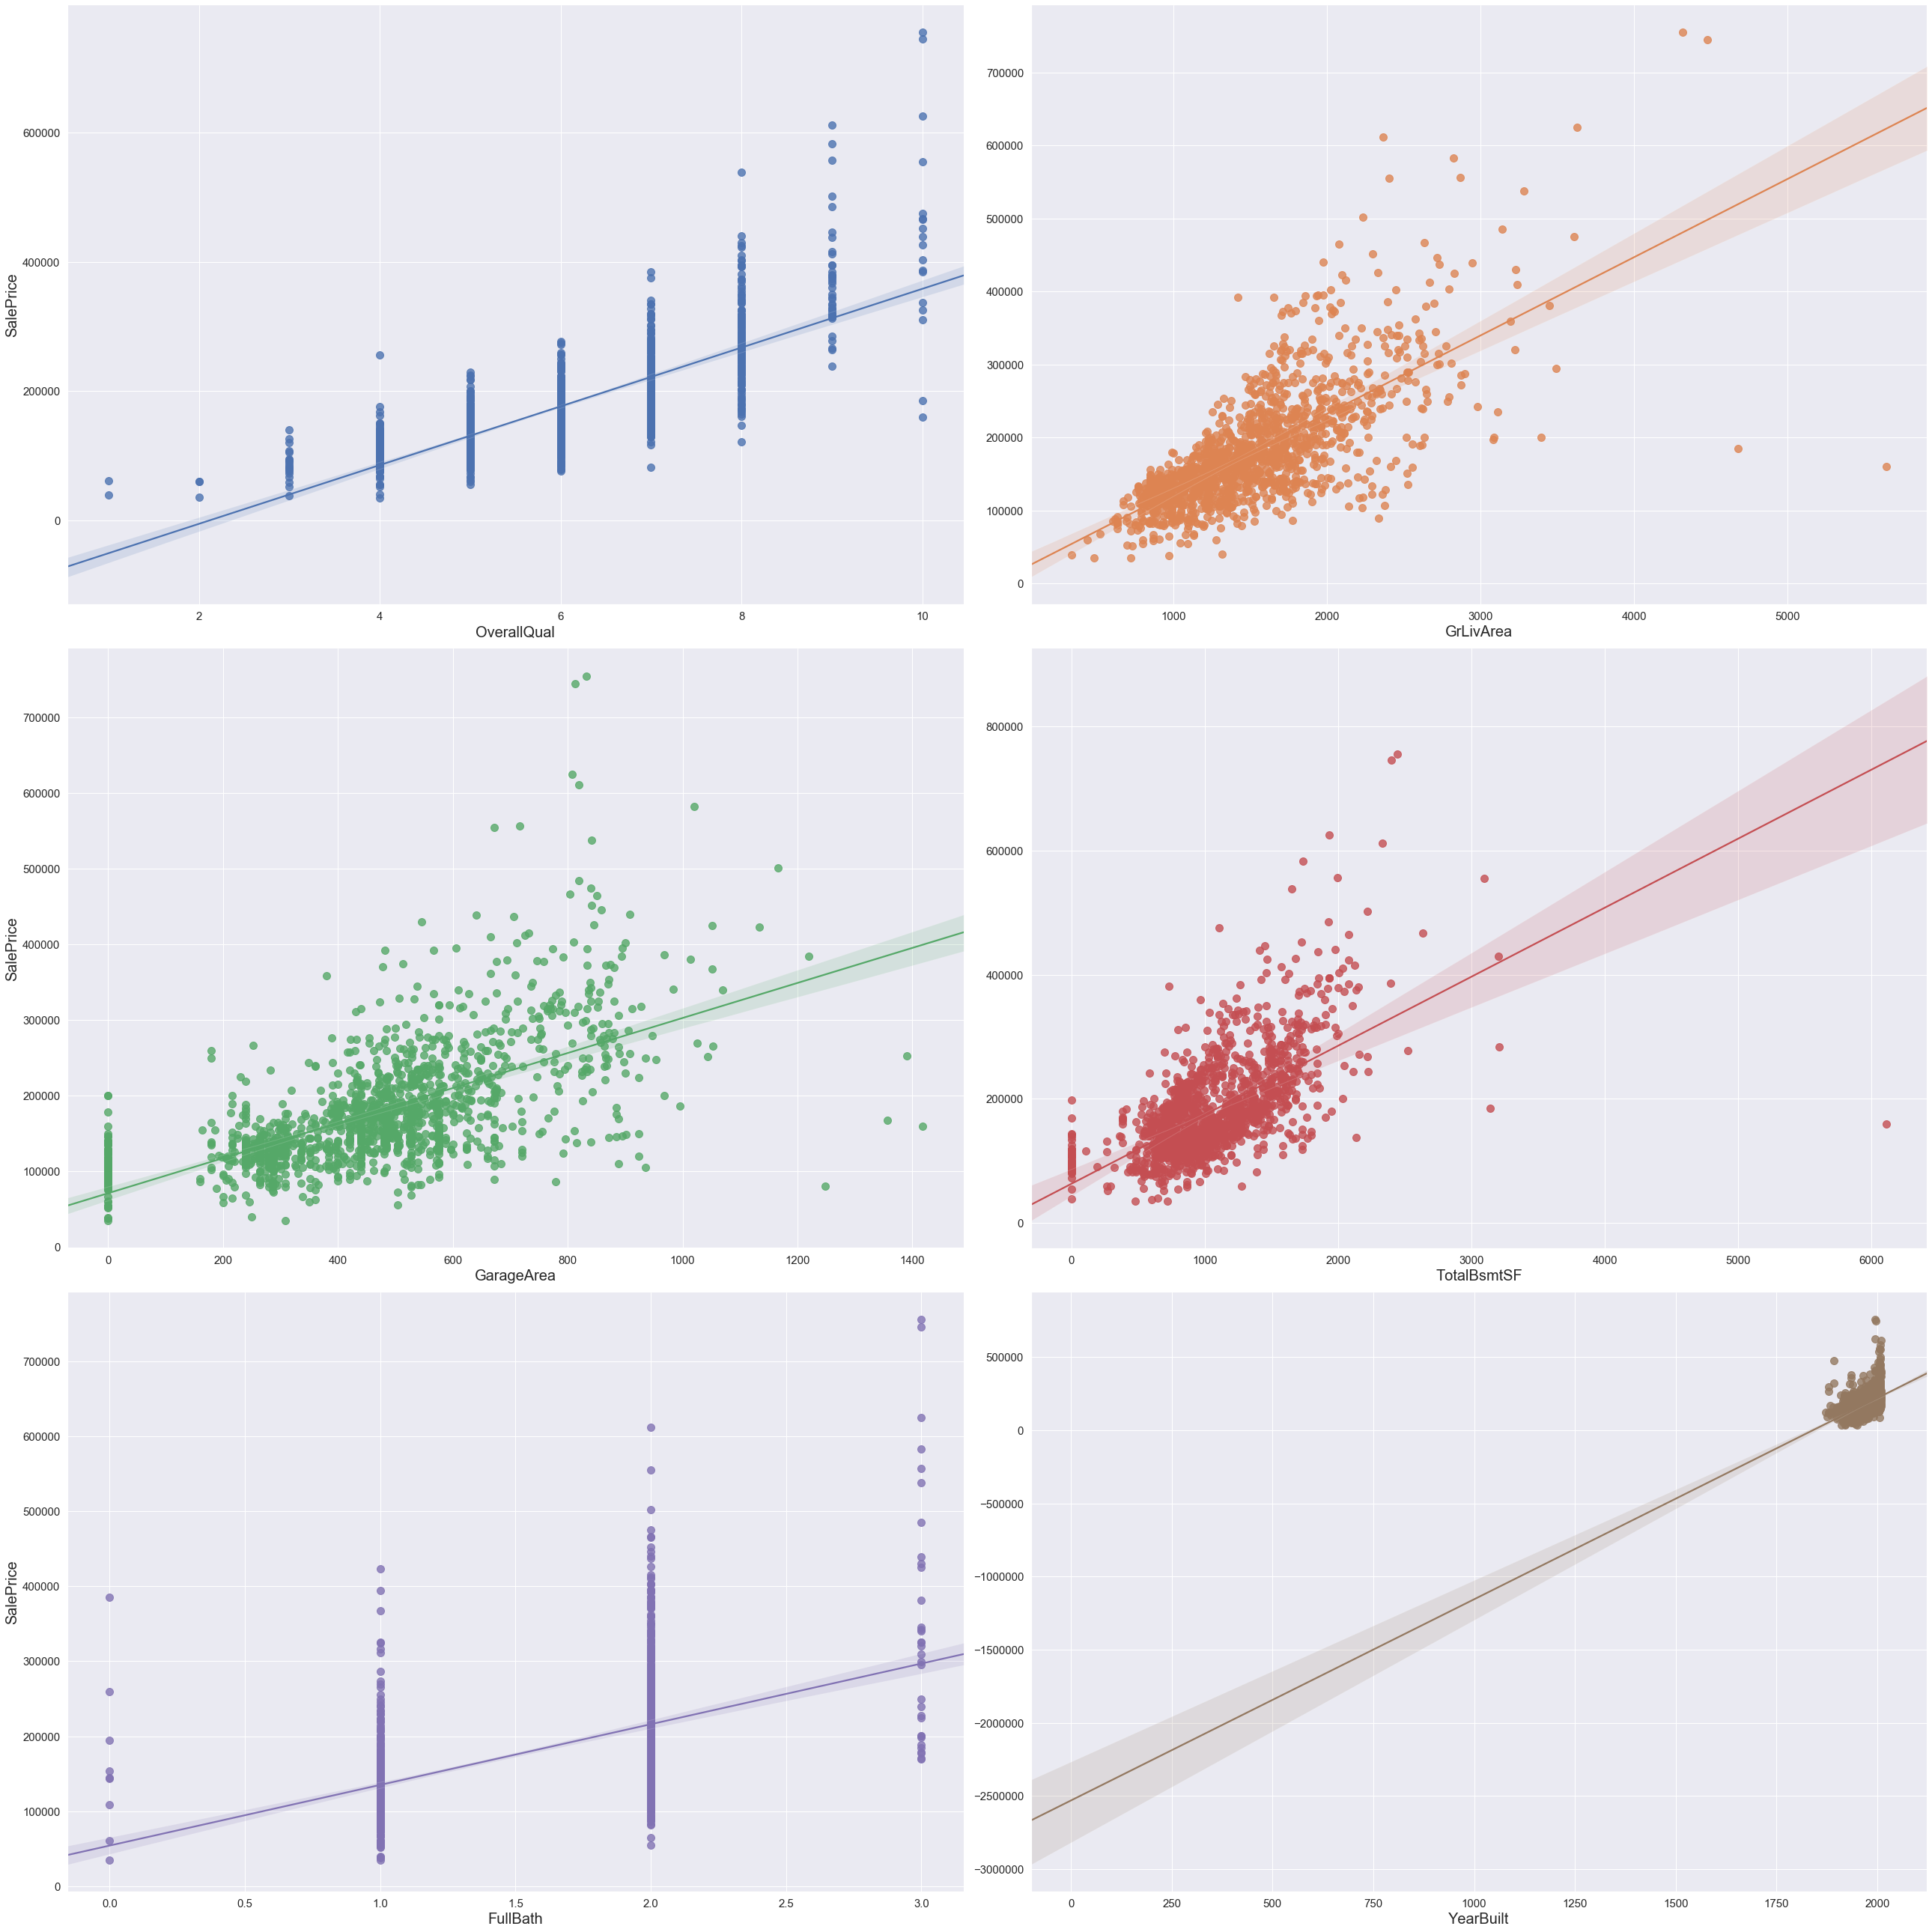

In [61]:
independent_var = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

fig, ax = plt.subplots(3, 2, figsize=(36, 36))
ax = ax.flatten() # ax is a two dimensional array. So if you want to use as[i], you must flatten ax

for i in range(len(independent_var)):
    sns.regplot(x = independent_var[i], y = 'SalePrice', data = df, ax=ax[i], marker = 'o', scatter_kws = {'s': 100})
    ax[i].set_xlabel(independent_var[i], fontsize=20)
    if i%2==0:
        ax[i].set_ylabel('SalePrice', fontsize = 20)
    else:
        ax[i].set_ylabel('')    
    ax[i].tick_params(axis='both', labelsize=15)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
plt.tight_layout()


/Users/zhenyufan/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


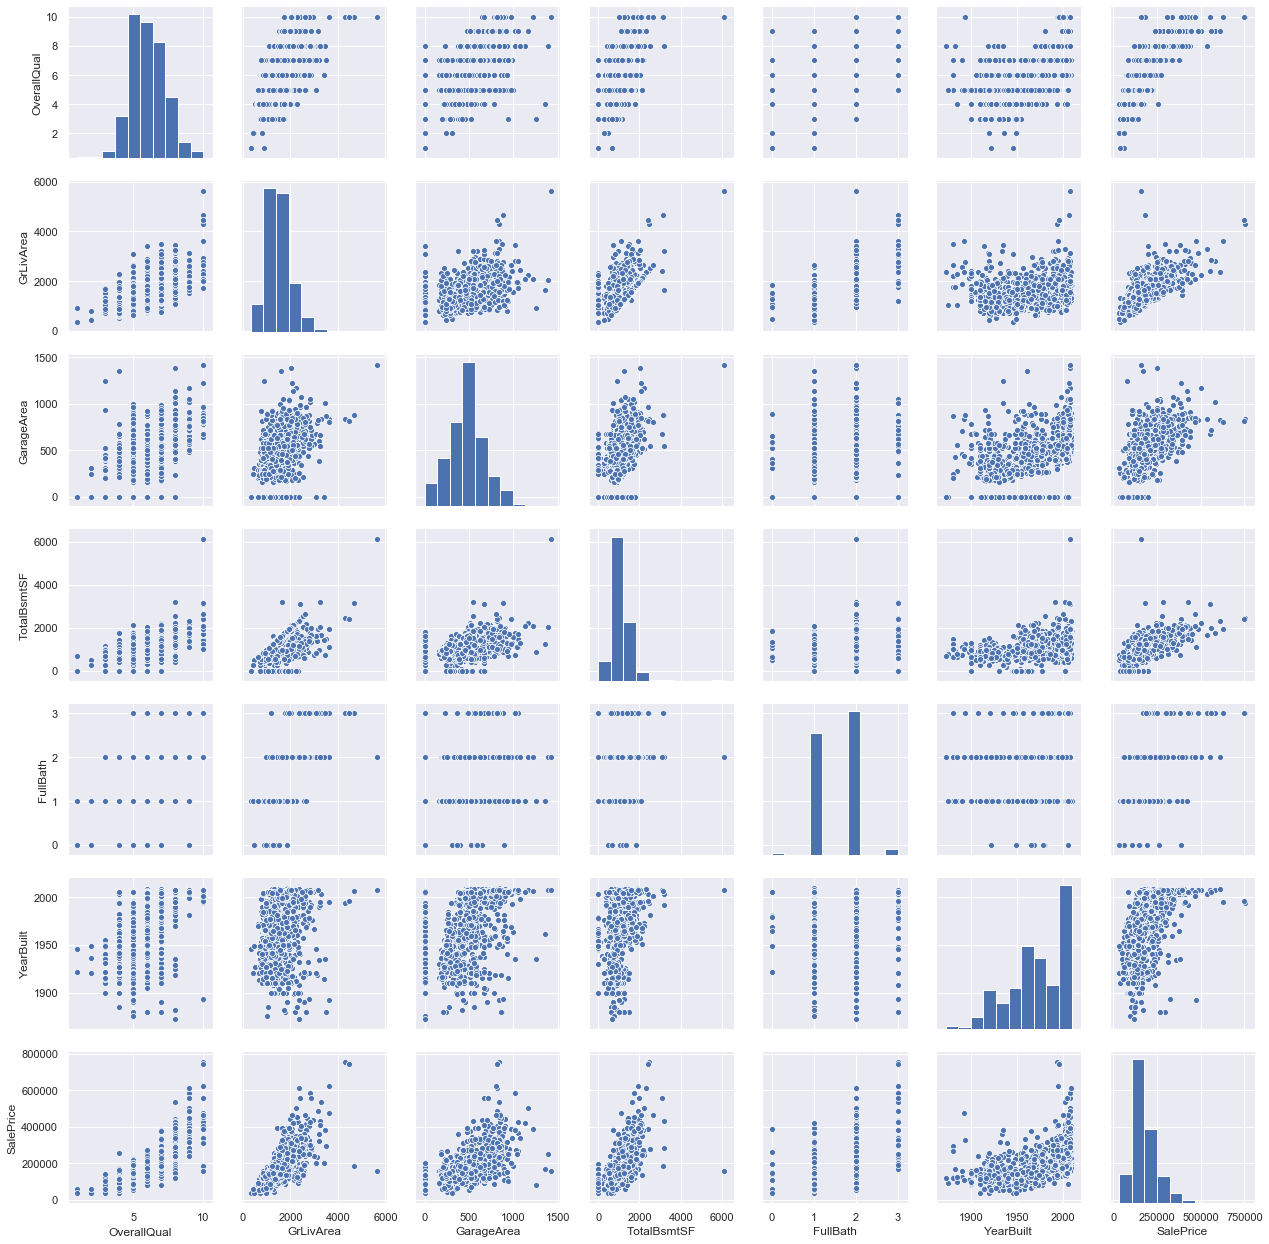

In [62]:
sns.set()
independent_var = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
cols = independent_var
cols.append('SalePrice')
sns.pairplot(df[cols], size = 2.5)
plt.show();

## Data Processing

In [63]:
df_train = df[cols]
df_train.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt,SalePrice
0,7,1710,548,856,2,2003,208500
1,6,1262,460,1262,2,1976,181500
2,7,1786,608,920,2,2001,223500
3,7,1717,642,756,1,1915,140000
4,8,2198,836,1145,2,2000,250000


### Remove outliers

From the pairplot, I found some extreme outliers for GrLivArea and TotalBsmtSF. The price is so low for some very big GrLivArea and TotalBsmtSF. Therefore, it should be safe to delete them.

Note: Outliers removal is not always safe. 

In [64]:
df_train = df_train.drop(df_train[(df_train.GrLivArea > 4000) & (df_train.SalePrice < 200000)].index)
df_train = df_train.drop(df_train[(df_train.TotalBsmtSF > 4000) & (df_train.SalePrice < 200000)].index)

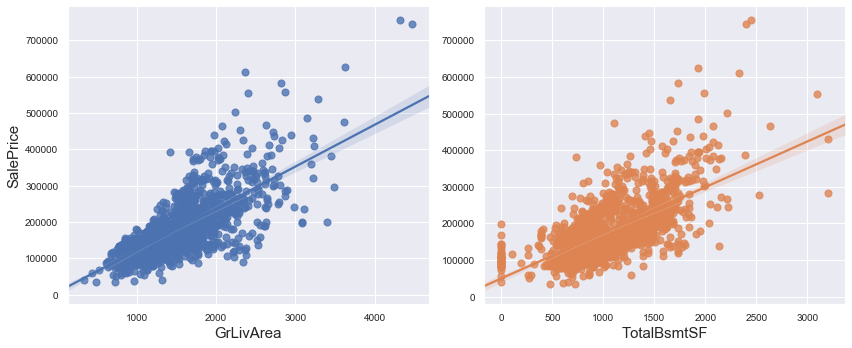

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.flatten()

sns.regplot(x = 'GrLivArea', y = 'SalePrice', data = df_train, ax=ax[0], marker = 'o', scatter_kws = {'s': 50})
ax[0].set_xlabel('GrLivArea', fontsize=15)
ax[0].set_ylabel('SalePrice', fontsize = 15) 
ax[0].tick_params(axis='both', labelsize=10)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

sns.regplot(x = 'TotalBsmtSF', y = 'SalePrice', data = df_train, ax=ax[1], marker = 'o', scatter_kws = {'s': 50})
ax[1].set_xlabel('TotalBsmtSF', fontsize=15)
ax[1].set_ylabel('', fontsize = 20) 
ax[1].tick_params(axis='both', labelsize=10)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()

Looks better now

### Log transaformation of target variable

From the above analysis, we have known that SalePrice is right skewed. We need to transform it


 mu = 12.02 and sigma = 0.40



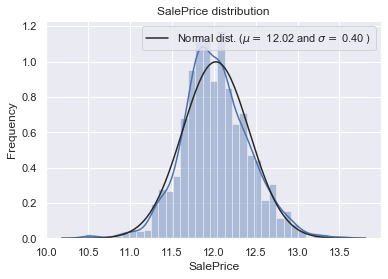

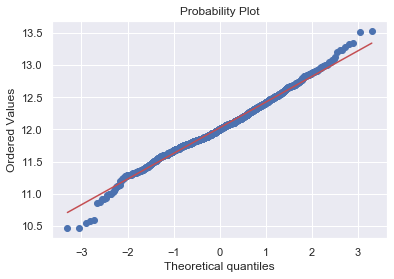

In [66]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()


### Log transformation of independent variables

In [67]:
numeric_vars = df_train.dtypes[df_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_train[numeric_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
GrLivArea,1.009951
TotalBsmtSF,0.511177
OverallQual,0.200579
GarageArea,0.131612
SalePrice,0.121455
FullBath,0.031239
YearBuilt,-0.611665


In [68]:
for feature in list(skewness[abs(skewness.Skew) > 0.75].index):
    df_train[feature] = np.log1p(df_train[feature])

#check the skewness again
numeric_vars = df_train.dtypes[df_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_train[numeric_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in adjusted numerical features: \n")
skewness_adjust = pd.DataFrame({'Skew' :skewed_feats})
skewness_adjust


Skew in adjusted numerical features: 



,Skew
TotalBsmtSF,0.511177
OverallQual,0.200579
GarageArea,0.131612
SalePrice,0.121455
FullBath,0.031239
GrLivArea,-0.070939
YearBuilt,-0.611665


In [240]:
df_train.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt,SalePrice
0,7,7.444833,548,856,2,2003,12.247699
1,6,7.141245,460,1262,2,1976,12.109016
2,7,7.488294,608,920,2,2001,12.317171
3,7,7.448916,642,756,1,1915,11.849405
4,8,7.695758,836,1145,2,2000,12.429220


## Modelling

In [204]:
#x_train, x_test, y_train, y_test = train_test_split(df_train[df_train.columns.difference(['SalePrice'])].values, df_train.SalePrice.values, test_size=0.2, random_state=42)
x_train = df_train[df_train.columns.difference(['SalePrice'])].values
y_train = df_train.SalePrice.values

n_folds=5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Different Models

#### Lasso

In [205]:
alpha_list = [0.0005, 0.005, 0.05, 0.5, 0]
lasso_result = pd.DataFrame(data=alpha_list, columns=['alpha'])

for a in alpha_list:
    lasso = make_pipeline(RobustScaler(), Lasso(alpha=a, random_state=1))
    score = rmsle_cv(lasso)
    lasso_result.loc[lasso_result['alpha'] == a, 'score'] = score.mean()

lasso_result

,alpha,score
0,0.0005,0.157695
1,0.0050,0.157976
2,0.0500,0.184032
3,0.5000,0.399468
4,0.0000,0.157675


#### Ridge

In [206]:
alpha_list = [0.0005, 0.005, 0.05, 0.5, 0]
ridge_result = pd.DataFrame(data=alpha_list, columns=['alpha'])

for a in alpha_list:
    ridge = make_pipeline(RobustScaler(), Ridge(alpha=a, random_state=1))
    score = rmsle_cv(ridge)
    ridge_result.loc[ridge_result['alpha'] == a, 'score'] = score.mean()

ridge_result

,alpha,score
0,0.0005,0.157675
1,0.0050,0.157675
2,0.0500,0.157675
3,0.5000,0.157675
4,0.0000,0.157675


#### Elastic Net Regression

In [207]:
grid_values = {'alpha': [0.0005, 0.005, 0.05, 0.5, 0], 'l1_ratio':list(np.arange(0,1,0.1)), 'random_state': list(range(0,5,1))}

eln = ElasticNet()
grid_clf_eln = GridSearchCV(eln, param_grid=grid_values,cv=5, scoring='r2')
grid_clf_eln.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0005, 0.005, 0.05, 0.5, 0],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                      0.5, 0.6000000000000001,
                                      0.7000000000000001, 0.8, 0.9],
                         'random_state': [0, 1, 2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [208]:
grid_clf_eln.best_params_

{'alpha': 0.0005, 'l1_ratio': 0.0, 'random_state': 0}

### Test on Testing Data

In [309]:
df_test = pd.read_csv('test.csv')
df_test = df_test[['Id', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]
df_test = df_test.fillna(df_test.mean())
df_id = df_test.Id
df_test = df_test.drop(columns=['Id'], axis=1)

numeric_vars = df_test.dtypes[df_test.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_test[numeric_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
GrLivArea,1.129240
TotalBsmtSF,0.813031
GarageArea,0.300033
FullBath,0.295534
OverallQual,0.181010
YearBuilt,-0.587052


In [310]:
for feature in list(skewness[abs(skewness.Skew) > 1].index):
    df_test[feature] = np.log1p(df_test[feature])

#check the skewness again
numeric_vars = df_test.dtypes[df_test.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_test[numeric_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in adjusted numerical features: \n")
skewness_adjust = pd.DataFrame({'Skew' :skewed_feats})
skewness_adjust


Skew in adjusted numerical features: 



,Skew
TotalBsmtSF,0.813031
GarageArea,0.300033
FullBath,0.295534
OverallQual,0.181010
GrLivArea,0.028347
YearBuilt,-0.587052


In [312]:
df_test = df_test[['FullBath', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF','YearBuilt']]
x_test = df_test.values

In [313]:
#Elastic Net
eln = ElasticNet(alpha=0.0005, random_state=0, l1_ratio=0)
eln.fit(x_train, y_train)
y_pred_e = eln.predict(x_test)
y_pred = np.expm1(y_pred_e)

In [314]:
result = pd.DataFrame()
result['Id'] = df_id
result['SalePrice'] = y_pred
result.head()

,Id,SalePrice
0,1461,124202.169873
1,1462,158036.280140
2,1463,164776.388964
3,1464,179962.440981
4,1465,208687.620514


In [316]:
result.to_csv('submission.csv', index=False)